# 모션 감지

## 08-01. 프레임차이 검출

In [1]:
import cv2

cap = cv2.VideoCapture(0)

ret, prev = cap.read()
if not ret: raise RuntimeError("첫 프레임 읽기 실패")
prev_gray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)

while True:
    ret, frame = cap.read()
    if not ret: break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # 1. 현재 프레임 - 이전 프레임 차이
    diff = cv2.absdiff(prev_gray, gray)

    # 2. 임계값 처리 (움직임이 있는 부분만 흰색)
    _, thresh = cv2.threshold(diff, 30, 255, cv2.THRESH_BINARY)

    cv2.imshow("Motion Mask", thresh)

    prev_gray = gray  # 프레임 갱신

    if cv2.waitKey(30) & 0xFF == ord('q'): break

cap.release()
cv2.destroyAllWindows()


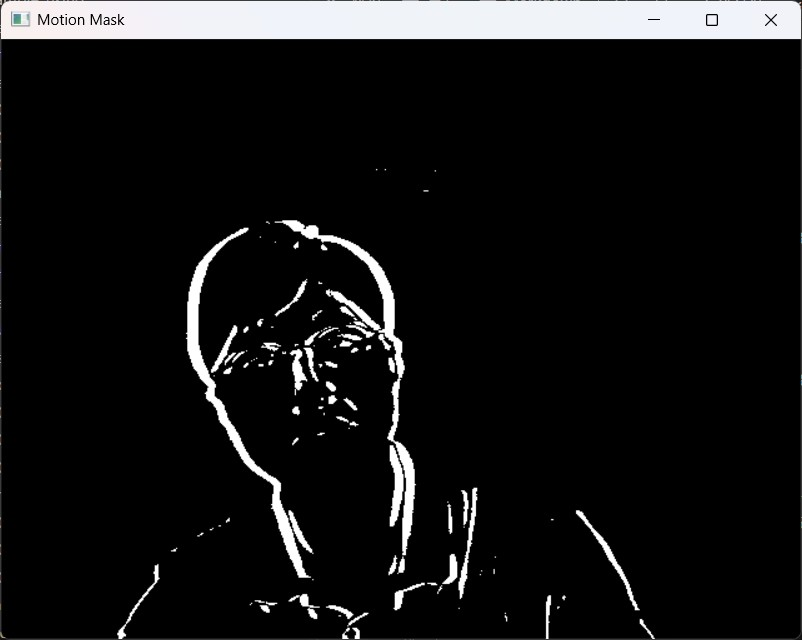

## 08-02 모폴로지 연산

In [2]:
import cv2
import numpy as np

# 웹캠 열기
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise RuntimeError("웹캠을 열 수 없습니다.")

# 모폴로지 커널 (5x5)
kernel = np.ones((5, 5), np.uint8)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # 그레이 변환
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # 이진화 (노이즈 제거 전에 필요)
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

    # --- 모폴로지 연산 ---
    # 작은 점 제거 (열기: 침식 후 팽창)
    mask = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    # 빈 공간 메우기 (팽창)
    mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, kernel)

    # 결과 출력
    cv2.imshow("Original", frame)
    cv2.imshow("Threshold", thresh)
    cv2.imshow("Morphology (Open + Dilate)", mask)

    if cv2.waitKey(1) & 0xFF == ord('q'):  # q 키 종료
        break

cap.release()
cv2.destroyAllWindows()


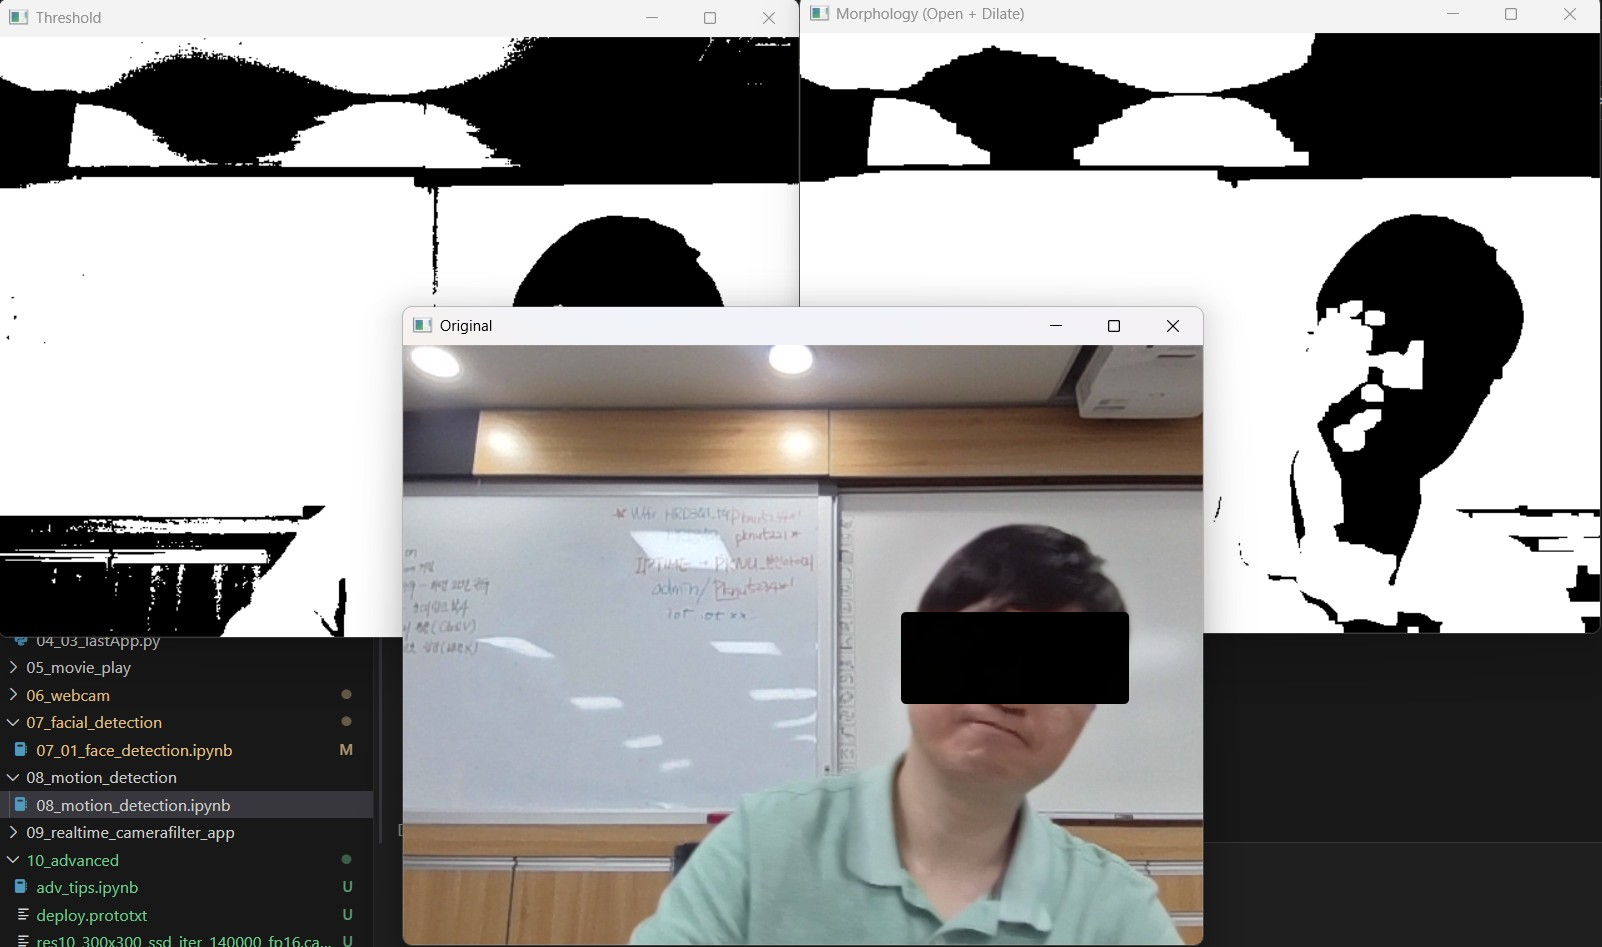

### 조금 다른 버전

In [3]:
import cv2
import numpy as np

# 웹캠 열기
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise RuntimeError("웹캠을 열 수 없습니다.")

# 모폴로지 커널 (크면 효과↑, 과하면 디테일↓)
K = 5  # 3, 5, 7 등 홀수 권장
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (K, K))

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # 그레이로 변환 (모폴로지는 바이너리/그레이 둘 다 가능)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # 1) 열기(Opening) = 침식 → 팽창 : 작은 밝은 점(소금 노이즈) 제거에 효과적
    opened = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel, iterations=1)

    # 2) 닫기(Closing) = 팽창 → 침식 : 작은 어두운 구멍 메우기에 효과적
    closed = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel, iterations=1)

    # 보기 좋게 나란히 출력
    opened_bgr = cv2.cvtColor(opened, cv2.COLOR_GRAY2BGR)
    closed_bgr = cv2.cvtColor(closed, cv2.COLOR_GRAY2BGR)
    montage = cv2.hconcat([frame, opened_bgr, closed_bgr])

    cv2.imshow("Morphology Only  |  Original | Opening | Closing", montage)

    if cv2.waitKey(1) & 0xFF == ord('q'):  # q로 종료
        break

cap.release()
cv2.destroyAllWindows()


## 08-03 윤곽선 추출

In [4]:
import cv2
import numpy as np

# 파라미터(필요시 조절)
THRESH     = 30             # 움직임 민감도(낮을수록 민감)
MIN_AREA   = 500            # 너무 작은 움직임 무시(픽셀 면적)
KERNEL     = np.ones((5,5), np.uint8)  # 모폴로지 커널

# 웹캠 열기
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise RuntimeError("웹캠을 열 수 없습니다.")

# 첫 프레임을 기준으로 사용
ret, prev = cap.read()
if not ret:
    cap.release()
    raise RuntimeError("첫 프레임 읽기 실패")
prev_gray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)

print("[키] q: 종료, c: 기준 프레임 리셋")
while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # 1) 프레임 차이
    diff = cv2.absdiff(prev_gray, gray)

    # 2) 이진화(움직임 마스크)
    _, mask = cv2.threshold(diff, THRESH, 255, cv2.THRESH_BINARY)

    # 3) 모폴로지로 노이즈 제거(선택)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN,  KERNEL, iterations=1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, KERNEL, iterations=2)

    # 4) 윤곽선 → 모든 움직임에 사각형 박스
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for c in contours:
        if cv2.contourArea(c) < MIN_AREA:   # 작은 흔들림 무시
            continue
        x, y, w, h = cv2.boundingRect(c)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0,255,0), 2)

    # 표시
    cv2.imshow("Motion Boxes", frame)
    # (선택) 마스크도 보고 싶으면 아래 주석 해제
    # cv2.imshow("Mask", mask)

    # 다음 비교용 기준 프레임 갱신
    prev_gray = gray

    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break
    elif key == ord('c'):
        prev_gray = gray.copy()  # 조명 바뀌면 기준 리셋

cap.release()
cv2.destroyAllWindows()


[키] q: 종료, c: 기준 프레임 리셋


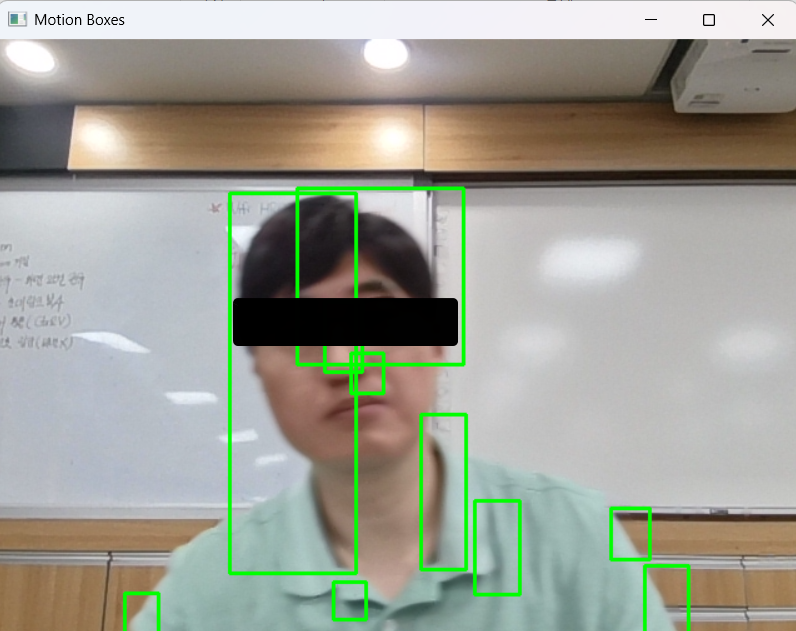

## 08-04 중심좌표 표시

In [5]:
import cv2
import numpy as np

# 파라미터 (원하는대로 조절)
THRESH     = 30             # 움직임 민감도 (낮을수록 민감)
MIN_AREA   = 500            # 너무 작은 움직임 무시 (픽셀 면적)
KERNEL     = np.ones((5,5), np.uint8)  # 모폴로지 커널

# 웹캠 열기
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise RuntimeError("웹캠을 열 수 없습니다.")

# 첫 프레임을 기준으로 사용
ret, prev = cap.read()
if not ret:
    cap.release()
    raise RuntimeError("첫 프레임 읽기 실패")
prev_gray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)

print("[키] q: 종료, c: 기준 프레임 리셋")
while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # 1) 프레임 차이
    diff = cv2.absdiff(prev_gray, gray)

    # 2) 이진화 (움직임 마스크)
    _, mask = cv2.threshold(diff, THRESH, 255, cv2.THRESH_BINARY)

    # 3) 모폴로지로 노이즈 제거
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN,  KERNEL, iterations=1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, KERNEL, iterations=2)

    # 4) 윤곽선 찾기
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for c in contours:
        if cv2.contourArea(c) < MIN_AREA:   # 작은 흔들림 무시
            continue

        # (a) 사각형 박스
        x, y, w, h = cv2.boundingRect(c)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0,255,0), 2)

        # (b) 중심점
        M = cv2.moments(c)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            cv2.circle(frame, (cx, cy), 6, (0, 0, 255), -1)
            cv2.putText(frame, f"({cx},{cy})", (cx+8, cy-8),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2, cv2.LINE_AA)

    # 결과 표시
    cv2.imshow("Motion Tracking", frame)
    cv2.imshow("Mask", mask)

    # 다음 프레임 기준 갱신
    prev_gray = gray

    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break
    elif key == ord('c'):
        prev_gray = gray.copy()  # 조명 변화를 대비해 기준 리셋

cap.release()
cv2.destroyAllWindows()


[키] q: 종료, c: 기준 프레임 리셋


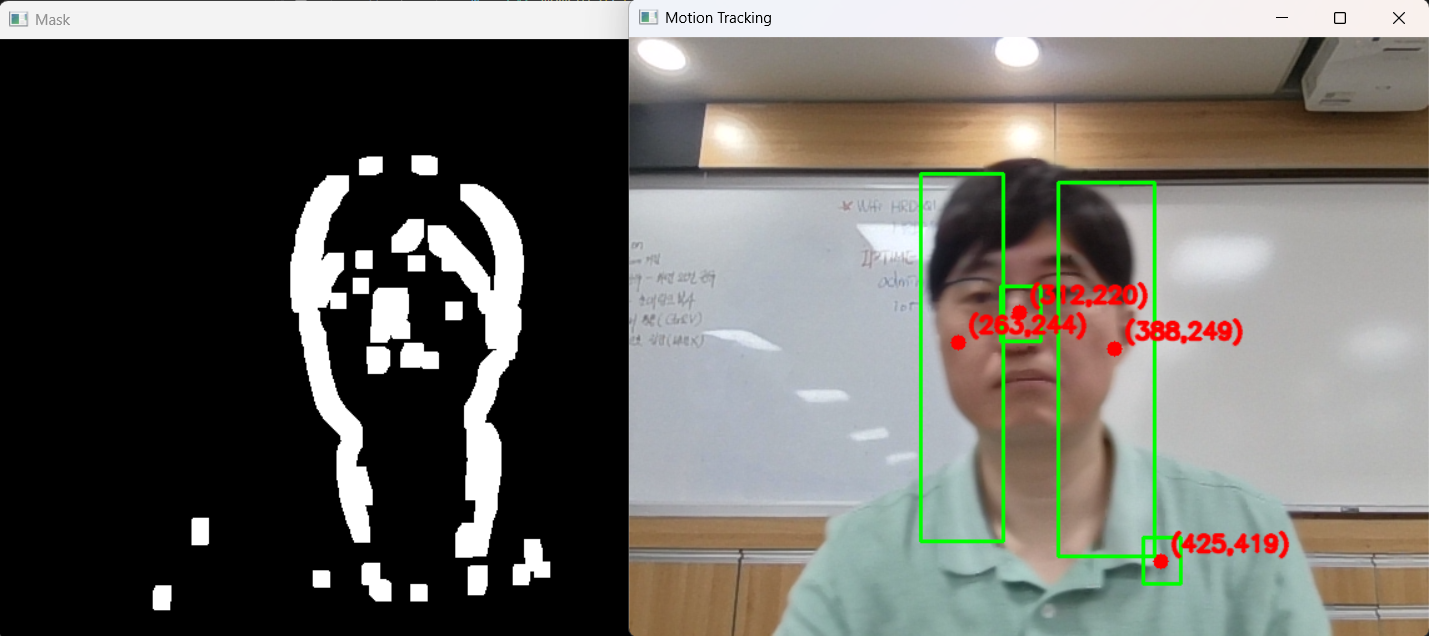

### 전체 통합

In [6]:
import cv2
import numpy as np

cap = cv2.VideoCapture(0)

ret, prev = cap.read()
if not ret: raise RuntimeError("첫 프레임 읽기 실패")
prev_gray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)

kernel = np.ones((5,5), np.uint8)

while True:
    ret, frame = cap.read()
    if not ret: break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # 프레임 차이
    diff = cv2.absdiff(prev_gray, gray)
    _, mask = cv2.threshold(diff, 30, 255, cv2.THRESH_BINARY)

    # 노이즈 제거
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, kernel)

    # 윤곽선 검출
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        if cv2.contourArea(cnt) < 500:  # 너무 작은 움직임 무시
            continue
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(frame, (x,y), (x+w,y+h), (0,255,0), 2)

        # 중심 좌표 추적
        M = cv2.moments(cnt)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            cv2.circle(frame, (cx, cy), 5, (0,0,255), -1)

    cv2.imshow("Motion Tracking", frame)
    prev_gray = gray

    if cv2.waitKey(30) & 0xFF == ord('q'):
        break


cap.release()
cv2.destroyAllWindows()


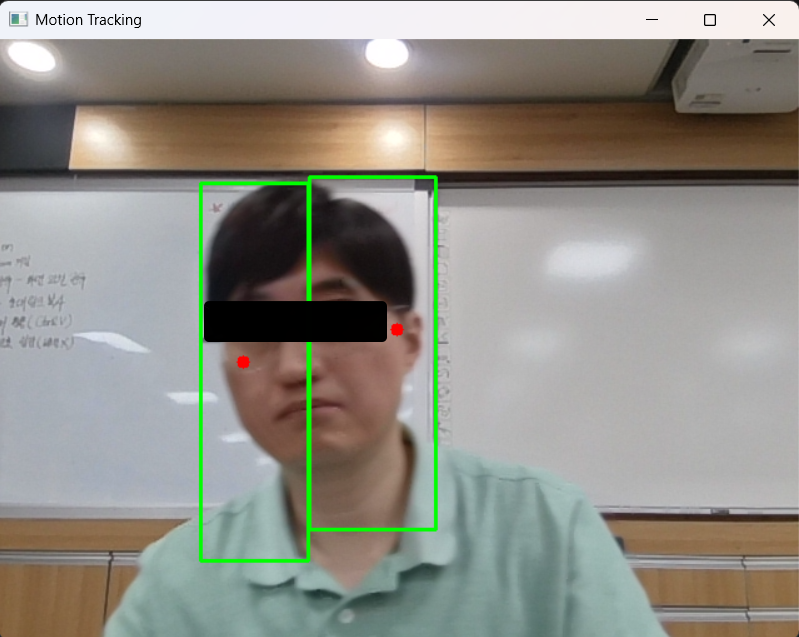